# Energy resolution for Xe0nu MC

## Penthesilea config

In [ ]:
# penthesilea.conf

files_in = '/lscratch/jjgomez/Xe0nu_penthesilea_0//Xe0nu_NEW_v1_05_02_nexus_v5_03_10_10.1bar_minicastle.0_pmaps.h5'
file_out = '/lscratch/jjgomez/Xe0nu_penthesilea_0//Xe0nu_NEW_v1_05_02_nexus_v5_03_10_10.1bar_minicastle.0_hdst.h5'

run_number = -6400

print_mod = 100
event_range =  all


# Penthesilea produces a hit collection starting from PMAPS. Since it
# also applies a selection to PMAPS it takes the parameters of
# s12_selector.

drift_v = 1. * mm / mus # Expected drift velocity

s1_nmin     =    1
s1_nmax     =    1
s1_emin     =    0 * pes # Min S1 energy integral
s1_emax     = 1e+6 * pes # Max S1 energy integral
s1_wmin     =  1 * ns # min width for S1
s1_wmax     =  1.e6 * ns # Max width
s1_hmin     =    0 * pes # Min S1 height
s1_hmax     = 1e+6 * pes # Max S1 height
s1_ethr     =  0.5 * pes # Energy threshold for S1

s2_nmin     =     1
s2_nmax     =     100       # Max number of S2 signals
s2_emin     =     0 * pes # Min S2 energy integral
s2_emax     =  1e+7 * pes # Max S2 energy integral in pes
s2_wmin     =     3 * mus # Min width
s2_wmax     =    10 * ms  # Max width
s2_hmin     =     0 * pes # Min S2 height
s2_hmax     =  1e+6 * pes # Max S2 height
s2_nsipmmin =     1       # Min number of SiPMs touched
s2_nsipmmax =   2000       # Max number of SiPMs touched
s2_ethr     =     0. * pes # Energy threshold for S2

# compression library
compression = 'ZLIB4'

rebin = 2  # if set to 1 no rebin is set to n rebin n times the wfm

slice_reco_params = dict(
Qthr           =    3. * pes,  # charge threshold, ignore all SiPMs with less than Qthr pes
Qlm            =   35 * pes,  # every Cluster must contain at least one SiPM with charge >= Qlm

# lm_radius = radius, find new_local_maximum by taking the barycenter of SiPMs within
#             lm_radius of the max sipm. new_local_maximum is new in the sense that the
#             prev loc max was the position of hottest_sipm. (Then allow all SiPMs with
#             new_local_maximum of new_local_maximum to contribute to the pos and q of the
#             new cluster).
# ***In general lm_radius should typically be set to 0, or some value slightly
# larger than pitch or pitch*sqrt(2).***
# ***If lm_radius is set to a negative number, the algorithm will simply return
# the overall barycenter all the SiPms above threshold.***
lm_radius      =   0 * mm,  # by default, use 3x3 corona

# new_lm_radius = radius, find a new cluster by calling barycenter() on pos/qs of SiPMs within
#                 new_lm_radius of new_local_maximum
new_lm_radius  =  15 * mm,  # by default, use 3 x3 corona
msipm          =   6       # minimum number of SiP
)


global_reco_params = dict(
    Qthr           =   0 * pes,
    lm_radius      =   -1)



In [1]:
from glob import glob
import numpy as np
import pandas as pd
import invisible_cities.io.dst_io as dstf
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from krcal.core.io_functions       import read_maps
from krcal.core.xy_maps_functions  import draw_xy_maps

from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction

from krcal.core.map_functions   import amap_max

from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy

from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo
from krcal.core.kr_types            import PlotLabels, FitType

## Read all events

In [3]:
files = glob('/home/jmbenlloch/next/new/Xe0nu/penthesilea/*h5')

In [4]:
def get_file_index(fname):
    return int(fname.split('.')[-2].split('_')[0])

In [5]:
files.sort(key=get_file_index)

In [11]:
data_partial = [dstf.load_dst(f, '/DST', 'Events') for f in files]

In [12]:
data = pd.concat(data_partial)

Number of events:

In [13]:
nevents = data.event.nunique()
nevents

400589

## Read mc info

In [14]:
import invisible_cities.io.mcinfo_io as mcio

In [15]:
evts_to_process  = {}
evts_to_volumes  = {}

for i, f in enumerate(files):
    mcparticles = mcio.load_mcparticles(f)
        
    for evt, particles in mcparticles.items():
        evts_to_process [evt] = np.unique([p.process      for _, p in particles.items()])
        evts_to_volumes [evt] = np.unique([p.final_volume for _, p in particles.items()])

In [16]:
def check_brems_evt(evt_id):
    return 'eBrem' in evts_to_process[evt_id]

In [17]:
def check_fully_contained(evt_id):
    return len(evts_to_volumes[evt_id]) == 1 and evts_to_volumes[evt_id][0] == 'ACTIVE'

Add to the dataframe whethet event has bremsstrahlung and is fully contained or not

In [18]:
data['brems']     = data.apply(lambda row: check_brems_evt      (row['event']), axis=1)
data['contained'] = data.apply(lambda row: check_fully_contained(row['event']), axis=1)

## Read correction map

In [19]:
map_file = '/home/jmbenlloch/next/new/Kr/maps/kr_emap_xy_100_100_mc.h5'

In [20]:
map_x_range = (-200, 200)
map_y_range = (-200, 200)
map_x_bins  = 100
map_y_bins  = 100

In [21]:
emaps = read_maps(map_file)

In [22]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number   -6400
dtype: int64

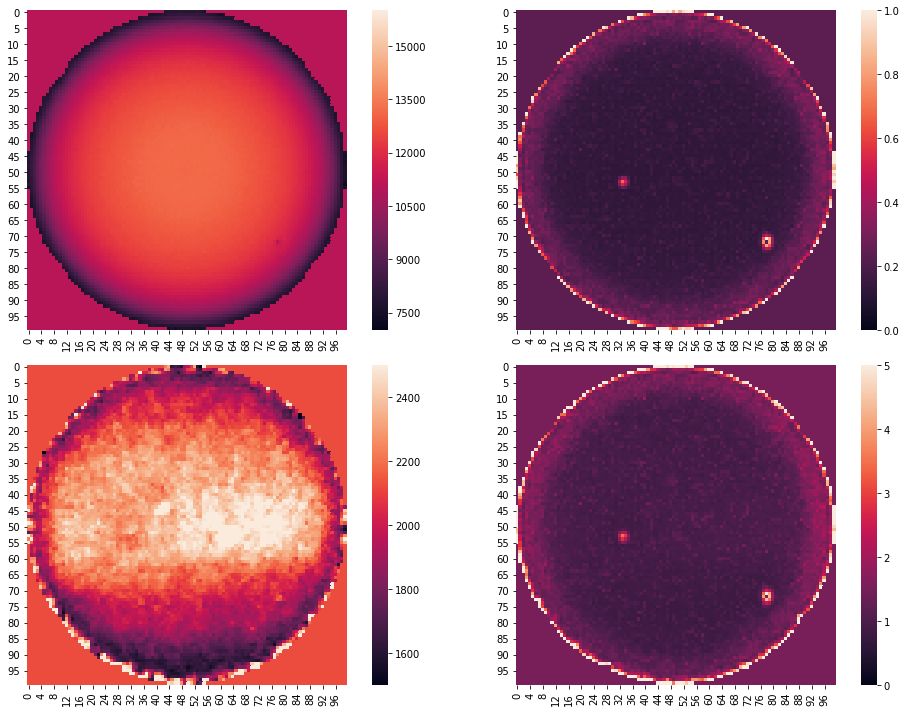

In [23]:
draw_xy_maps(emaps,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [24]:
norm = amap_max(emaps)

## Apply corrections

In [25]:
E0 = e0_xy_correction(data.S2e.values,
                      data.X.values,
                      data.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = map_x_range,
                      yr  = map_y_range,
                      nx  = map_x_bins,
                      ny  = map_y_bins)

In [26]:
E = lt_xy_correction(E0, 
                     data.X.values, 
                     data.Y.values,
                     data.Z.values, 
                     LTM = emaps.lt,            
                     xr  = map_x_range,
                     yr  = map_y_range,
                     nx  = map_x_bins,
                     ny  = map_y_bins)

In [27]:
data['Ecorr'] = E

Compute energy for each event

In [28]:
events_energy = data[['event', 'Ecorr', 'S2e']].groupby('event').sum()

## Plot spectra

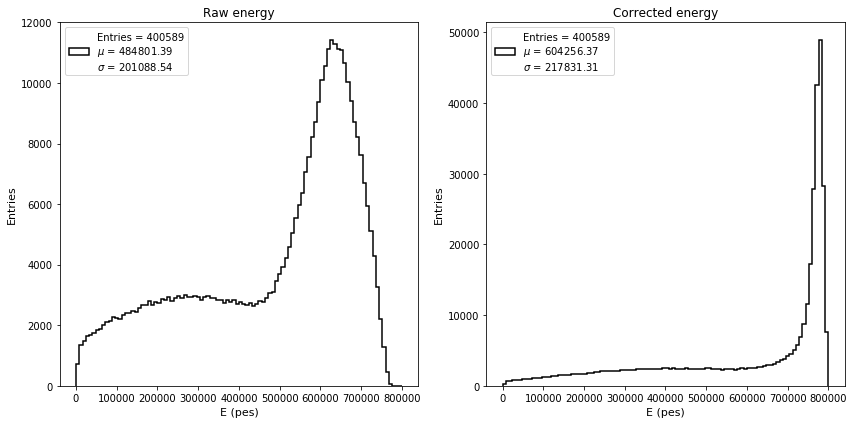

In [29]:
fig = plt.figure(figsize=(12,6))

ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(events_energy.S2e,  bins = 100, range =(0, 8e5))
plot_histo(PlotLabels('E (pes)','Entries','Raw energy'), ax, legendloc='upper left')

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(events_energy.Ecorr,  bins = 100, range =(0, 8e5))
plot_histo(PlotLabels('E (pes)','Entries','Corrected energy'), ax, legendloc='upper left')

plt.tight_layout()

### Fit spectrum

  Fit was valid = True
 Emu       = 774508.2068277181 +-30.85669505081568 
 E sigma   = 11300.675664139075 +-23.2900194423752 
 chi2    = 6.921130947340742 
 sigma E/E (FWHM)     (%) =3.42883233213229
 sigma E/E (FWHM) Qbb (%) =0.44284040367070476 


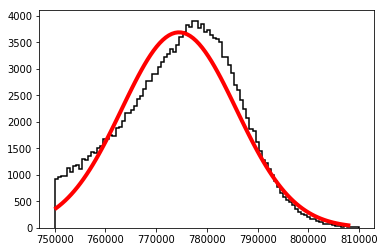

In [30]:
fc = fit_energy(events_energy.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

Not very gaussian...

# Apply cuts

### Fiducial cut: events with all hits in $r \in [0, 180]$

In [31]:
events_outside = data[data.R > 180].event
data_r = data[~data.event.isin(events_outside)]

In [32]:
events_energy_r = data_r[['event', 'Ecorr', 'S2e']].groupby('event').sum()

Number of evetns and efficiency:

In [33]:
nevents_r = len(events_energy_r)
print("Number of events: ", nevents_r)
print("Efficiency: ", nevents_r / nevents)

Number of events:  347071
Efficiency:  0.8664017234622019


  Fit was valid = True
 Emu       = 774616.0732806458 +-30.832848617748503 
 E sigma   = 11248.766474688511 +-23.268823034153765 
 chi2    = 6.816679430466579 
 sigma E/E (FWHM)     (%) =3.4126068548464863
 sigma E/E (FWHM) Qbb (%) =0.44074485153662685 


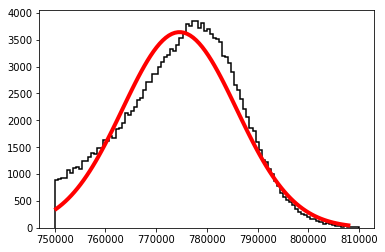

In [34]:
fc = fit_energy(events_energy_r.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

Not very gaussian either...

### Apply cut $z \in (20, 500)$ and $r \in [0, 180]$

In [35]:
data_filtered = data_r[(data_r.Z > 20) & (data_r.Z < 500)]

In [36]:
events_energy_filtered = data_filtered[['event', 'Ecorr']].groupby('event').sum()

Number of events and efficiency:

In [37]:
nevents_filtered = len(events_energy_filtered)
print("Number of events: ", nevents_filtered)
print("Efficiency: ", nevents_filtered / nevents)

Number of events:  323837
Efficiency:  0.8084021278667163


  Fit was valid = True
 Emu       = 774824.6615160287 +-31.272820508160763 
 E sigma   = 11231.595226802441 +-23.601385253557776 
 chi2    = 6.914805954614897 
 sigma E/E (FWHM)     (%) =3.406480213386925
 sigma E/E (FWHM) Qbb (%) =0.43995358380630584 


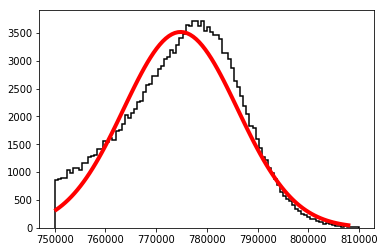

In [38]:
fc = fit_energy(events_energy_filtered.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

Not gaussian either

### Restrict even more to check if there is a lifetime effect $z \in (20, 300)$

In [39]:
data_filtered = data_r[(data_r.Z > 20) & (data_r.Z < 300)]

In [40]:
events_energy_filtered = data_filtered[['event', 'Ecorr']].groupby('event').sum()

Number of events and efficiency

In [41]:
nevents_filtered = len(events_energy_filtered)
print("Number of events: ", nevents_filtered)
print("Efficiency: ", nevents_filtered / nevents)

Number of events:  187742
Efficiency:  0.46866489094807895


  Fit was valid = True
 Emu       = 774550.8339721686 +-39.031252942227354 
 E sigma   = 10821.739413866222 +-29.405590132977025 
 chi2    = 5.146473983142016 
 sigma E/E (FWHM)     (%) =3.2833335795619862
 sigma E/E (FWHM) Qbb (%) =0.42404895513062746 


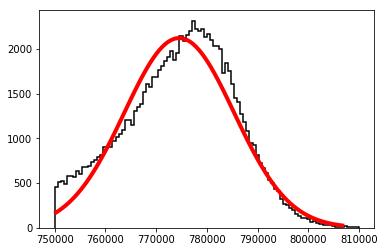

In [42]:
fc = fit_energy(events_energy_filtered.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

Still non-gaussian

### Filter bremstrahlung and $r \in [0, 180]$

In [43]:
data_nobrems = data_r[~data_r.brems]

In [44]:
events_energy_nobrems = data_nobrems[['event', 'Ecorr', 'S2e']].groupby('event').sum()

In [45]:
nevents_nobrems = len(events_energy_nobrems)
print("Number of events: ", nevents_nobrems)
print("Efficiency: ", nevents_nobrems / nevents)

Number of events:  65870
Efficiency:  0.1644328725951037


  Fit was valid = True
 Emu       = 774978.4594351513 +-69.37675546453285 
 E sigma   = 11181.70598457703 +-52.98177050483564 
 chi2    = 2.741495057340583 
 sigma E/E (FWHM)     (%) =3.390676056068476
 sigma E/E (FWHM) Qbb (%) =0.4379124459702586 


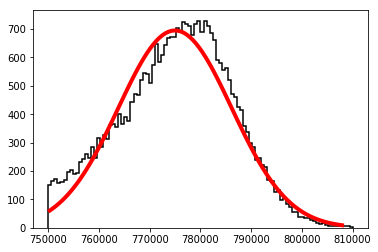

In [46]:
fc = fit_energy(events_energy_nobrems.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

### Fully contained and $r \in [0, 180]$

In [48]:
data_contained = data_r[data_r.contained]

In [49]:
events_energy_contained = data_contained[['event', 'Ecorr', 'S2e']].groupby('event').sum()

In [50]:
nevents_contained = len(events_energy_contained)
print("Number of events: ", nevents_contained)
print("Efficiency: ", nevents_contained / nevents)

Number of events:  190026
Efficiency:  0.4743664953356183


  Fit was valid = True
 Emu       = 774978.4594351513 +-69.37675546453285 
 E sigma   = 11181.70598457703 +-52.98177050483564 
 chi2    = 2.741495057340583 
 sigma E/E (FWHM)     (%) =3.390676056068476
 sigma E/E (FWHM) Qbb (%) =0.4379124459702586 


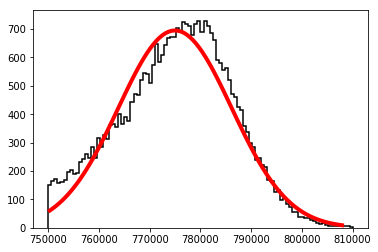

In [51]:
fc = fit_energy(events_energy_nobrems.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

### No brems & fully contained and $r \in [0 ,180]$

In [54]:
data_all = data_r[~data_r.brems & data_r.contained]

In [55]:
events_energy_all = data_all[['event', 'Ecorr', 'S2e']].groupby('event').sum()

In [56]:
nevents_all = len(events_energy_all)
print("Number of events: ", nevents_all)
print("Efficiency: ", nevents_all / nevents)

Number of events:  37479
Efficiency:  0.09355973329272646


  Fit was valid = True
 Emu       = 775062.1612171496 +-69.10193381908473 
 E sigma   = 11142.655029355283 +-52.79926126399657 
 chi2    = 2.718017520716796 
 sigma E/E (FWHM)     (%) =3.3784695769257898
 sigma E/E (FWHM) Qbb (%) =0.4363359553089075 


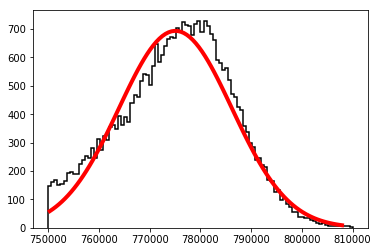

In [57]:
fc = fit_energy(events_energy_all.Ecorr.values, nbins=100, range=(750000, 810000))
plot_fit_energy(fc)
print_fit_energy(fc)

### Compare filters

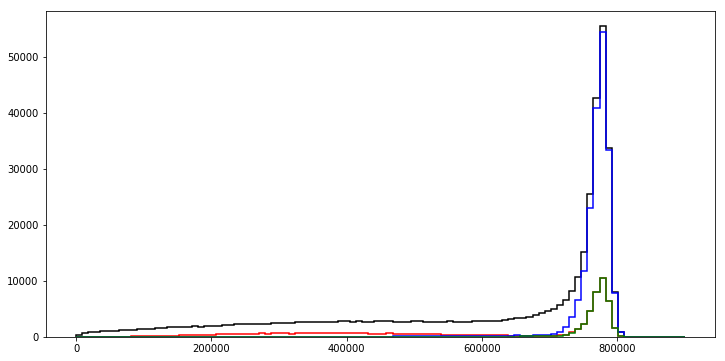

In [67]:
fig = plt.figure(figsize=(12,6))
(_)     = h1(events_energy          .Ecorr, bins = 100, range =(0, 9e5))
(_)     = h1(events_energy_nobrems  .Ecorr, bins = 100, range =(0, 9e5), color='red')
(_)     = h1(events_energy_contained.Ecorr, bins = 100, range =(0, 9e5), color='blue')
(_)     = h1(events_energy_all      .Ecorr, bins = 100, range =(0, 9e5), color='green')

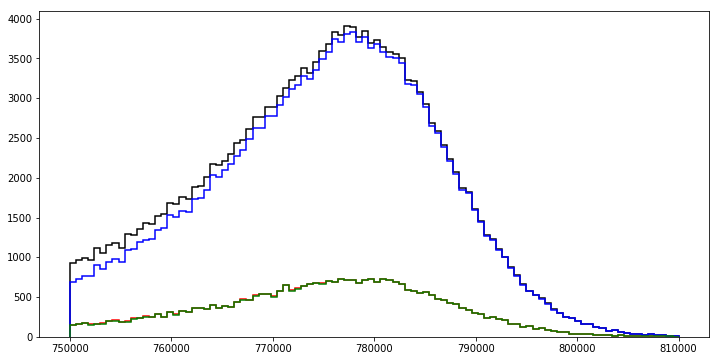

In [66]:
fig = plt.figure(figsize=(12,6))
(_)     = h1(events_energy          .Ecorr, bins = 100, range =(750000, 810000))
(_)     = h1(events_energy_nobrems  .Ecorr, bins = 100, range =(750000, 810000), color='red')
(_)     = h1(events_energy_contained.Ecorr, bins = 100, range =(750000, 810000), color='blue')
(_)     = h1(events_energy_all      .Ecorr, bins = 100, range =(750000, 810000), color='green')

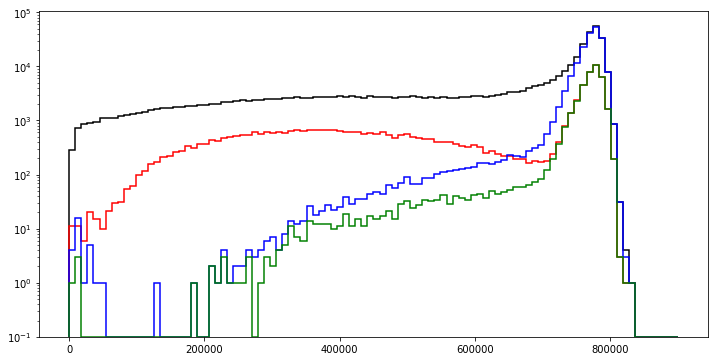

In [68]:
fig = plt.figure(figsize=(12,6))
(_)     = h1(events_energy          .Ecorr, bins = 100, range =(0, 9e5), log=True)
(_)     = h1(events_energy_nobrems  .Ecorr, bins = 100, range =(0, 9e5), color='red', log=True)
(_)     = h1(events_energy_contained.Ecorr, bins = 100, range =(0, 9e5), color='blue', log=True)
(_)     = h1(events_energy_all      .Ecorr, bins = 100, range =(0, 9e5), color='green', log=True)

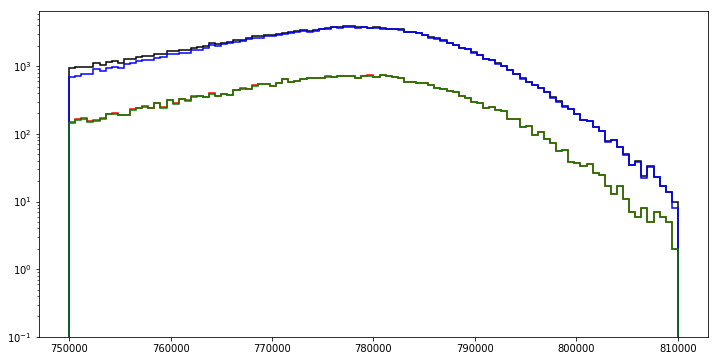

In [69]:
fig = plt.figure(figsize=(12,6))
(_)     = h1(events_energy          .Ecorr, bins = 100, range =(750000, 810000), log=True)
(_)     = h1(events_energy_nobrems  .Ecorr, bins = 100, range =(750000, 810000), color='red', log=True)
(_)     = h1(events_energy_contained.Ecorr, bins = 100, range =(750000, 810000), color='blue', log=True)
(_)     = h1(events_energy_all      .Ecorr, bins = 100, range =(750000, 810000), color='green', log=True)